In [20]:
import matplotlib.pyplot as plt
from spikeinterface import load_sorting_analyzer
import scipy.io
import numpy as np
from pathlib import Path
import os
import process_func.DIO as DIO
from scipy.signal import find_peaks
import pickle

In [48]:
animal_id = 'CnL22'
session_id = '20241203_123534'
ishs = ['0', '1', '2', '3']

rec_folder = rf"D:\cl\rf_reconstruction\freelymoving\{animal_id}_{session_id}.rec"
rec_folder = Path(rec_folder)

dio_folders = DIO.get_dio_folders(rec_folder)
dio_folders = sorted(dio_folders, key=lambda x:x.name)
pd_time, pd_state = DIO.concatenate_din_data(dio_folders, 2)


dlc_proc_file = r"D:\cl\video\Imaging_source_CnL22_2024-12-03_3_PROC"
with open(dlc_proc_file, 'rb') as f:
    dlc_proc = pickle.load(f)

\\10.129.151.108\xieluanlabs\xl_cl\code\process_func\readTrodesExtractedDataFile3.py:64: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  return np.dtype(typearr)


In [ ]:

def average_array(arr, block_size, axis=0):
    # Move the target axis to the front for easier indexing
    arr = np.moveaxis(arr, axis, 0)
    n = arr.shape[0]
    
    full_blocks = (n // block_size) * block_size
    # Average the full blocks
    averaged_data = arr[:full_blocks].reshape(-1, block_size, *arr.shape[1:]).mean(axis=1)

    # Handle the remainder
    remainder = n % block_size
    if remainder > 0:
        remainder_mean = arr[full_blocks:].mean(axis=0, keepdims=True)
        averaged_data = np.concatenate([averaged_data, remainder_mean], axis=0)
    
    # Move the axis back to its original position
    averaged_data = np.moveaxis(averaged_data, 0, axis)
    return averaged_data


In [56]:
ts_file = r"D:\cl\video\Imaging_source_CnL22_2024-12-03_3_TS.npy"
ts = np.load(ts_file)

averaged_ts = average_array(ts, 10)

In [23]:
unity_frame_folder = rec_folder / 'unity'
# load all images in unity folder in grayscale, and store them in a array
unity_frames = []
for unity_frame_file in unity_frame_folder.glob('*.png'):
    unity_frame = plt.imread(unity_frame_file)
    gray = np.dot(unity_frame[..., :3], [0.299, 0.587, 0.114])
    unity_frames.append(gray)
unity_frames = np.array(unity_frames)

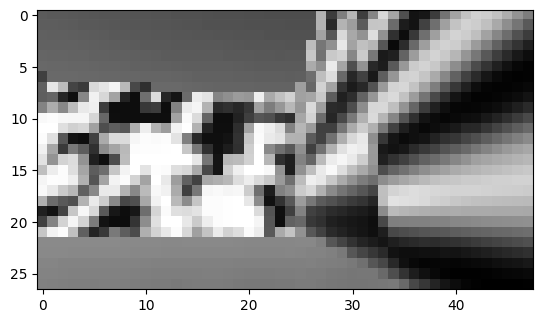

In [24]:
plt.imshow(unity_frames[1000], cmap='gray')

In [57]:
# read conf file
files = rec_folder.glob("head_conf_eye_conf*.npy")
full_paths = [os.path.abspath(f) for f in files]
conf_file = Path(full_paths[0])
conf = np.load(conf_file)

conf = average_array(conf, 10)

In [ ]:
# ish = 1
# rec_folder = rf'\\10.129.151.108\xieluanlabs\xl_cl\code\sortout\{animal_id}\{session_id}\{ish}'
# sorting_results_folders = []
# for root, dirs, files in os.walk(rec_folder):
#     for dir_name in dirs:
#         if dir_name.startswith('sorting_results_'):  # Check if the folder name matches the pattern
#             sorting_results_folders.append(os.path.join(root, dir_name))

In [27]:
sorting_results_folder = sorting_results_folders[0]

sorting_analyzer_folder = Path(sorting_results_folder) / 'sorting_analyzer'
out_fig_folder = Path(sorting_results_folder) / 'STA'
out_fig_folder = Path(out_fig_folder)
if not out_fig_folder.exists():
    out_fig_folder.mkdir(parents=True)


sorting_analyzer = load_sorting_analyzer(sorting_analyzer_folder)
print(sorting_analyzer)
sorting = sorting_analyzer.sorting

unit_ids = sorting.unit_ids
fs = sorting.sampling_frequency

SortingAnalyzer: 32 channels - 18 units - 1 segments - binary_folder - sparse - has recording
Loaded 8 extensions: amplitude_scalings, noise_levels, quality_metrics, random_spikes, spike_amplitudes, templates, template_metrics, waveforms


In [28]:
ephys_start_time = pd_time[0]

ephys_peaks

In [29]:
rising_edge, _ = find_peaks(pd_state)
print('rising edge numbers:', len(rising_edge))
ephys_peak_time = pd_time[rising_edge]

rising edge numbers: 7668


In [30]:
video_start = ts[0]

In [31]:
dlc_rising_edge, _ = find_peaks(dlc_proc['signal'])
print('rising edge numbers:', len(dlc_rising_edge))
dlc_peak_time = dlc_proc['signal_time'][dlc_rising_edge]

rising edge numbers: 7668


In [32]:
dlc_proc

{'signal': array([0., 0., 0., ..., 1., 1., 1.]),
 'signal_time': array([1.73325096e+09, 1.73325096e+09, 1.73325096e+09, ...,
        1.73325404e+09, 1.73325404e+09, 1.73325404e+09])}

In [33]:
unit_id = 1

In [34]:
spikes = sorting.get_unit_spike_train(unit_id) + ephys_start_time

In [35]:
ephys_first_rising = ephys_peak_time[0]
dlc_first_rising = dlc_peak_time[0]

In [ ]:
ts_aligned = averaged_ts - dlc_first_rising
spikes_aligned = (spikes - ephys_first_rising)/fs  # convert to seconds

In [60]:
prior_time = 0.2
ST = []

for i, spike in enumerate(spikes_aligned):
    if spike <= 0 or spike >= ts_aligned[-1]:
        continue
    idx = np.searchsorted(ts_aligned, spike-prior_time) - 1
    if idx < 0:
        continue

    if np.any(conf[idx] < 0.7):
        continue
    frame = unity_frames[idx]
    ST.append(frame)

ST = np.array(ST)
STA = np.mean(ST, axis=0)

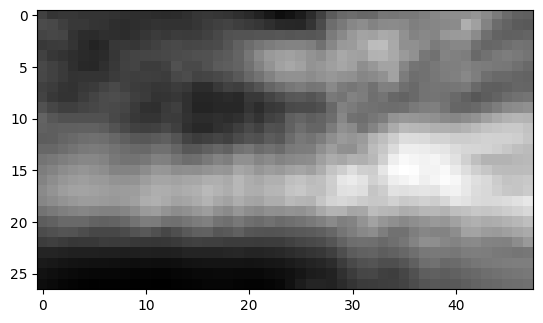

In [61]:
plt.imshow(STA, cmap='gray')